In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import time
from multiprocessing import Pool
from tqdm.auto import tqdm
import re

import numpy as np
from scipy import integrate, optimize
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
import matplotlib as mpl
import matplotlib.colors as mplc

mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.size'] = 6

mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.pad'] = 0.5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.pad'] = 0.5
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 3
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['legend.handletextpad'] = 0.4
mpl.rcParams['legend.columnspacing'] = 1.0
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['figure.subplot.top'] = 0.75
mpl.rcParams['figure.subplot.bottom'] = 0.25
mpl.rcParams['figure.subplot.left'] = 0.25
mpl.rcParams['figure.subplot.right'] = 0.75

In [3]:
filename = '20250302_L-sweep_clean.h5'
saved = nl.io.load.hdf5(filename)

In [4]:
data       = saved['data']
conditions = saved['conditions']

In [5]:
Ls = np.array([int(re.search('L=(\d+)$', cond)[1]) for cond in conditions])
Ls

array([ 30,  40, 100, 150, 175, 200, 250])

In [6]:
colors = {cond : plt.cm.viridis(i/(len(conditions)-1)) for i, cond in enumerate(conditions)}

In [7]:
data.makeSelection()
dt_H2B = np.mean([traj.meta['dt'] for traj in data])
print(dt_H2B*1e6)

216.57027379296593


# Plotting

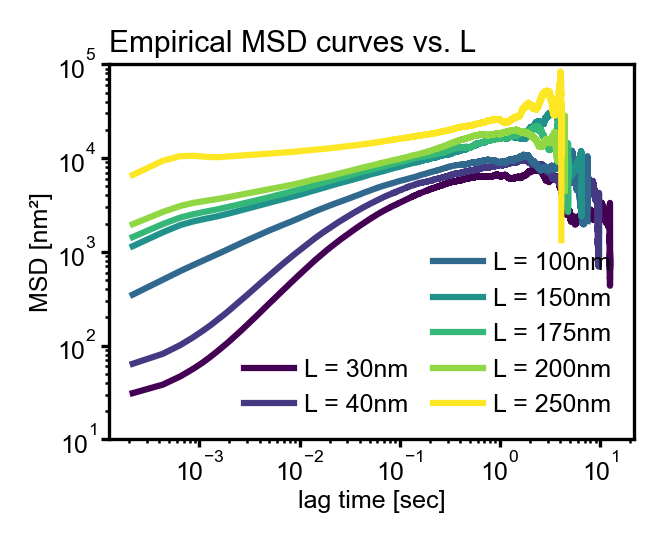

In [9]:
fig = plt.figure(figsize=[3.5, 2.5])
ax = plt.gca()

ax.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment
ax.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment
ax.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment

MSD1 = []
for L, cond in zip(Ls, conditions):
    dt = dt_H2B

    data.makeSelection(cond)
    msd = nl.analysis.MSD(data)*1e18
    
    MSD1.append(msd[1])
    
    ax.plot(dt*np.arange(1, len(msd)), msd[1:],
            color=colors[cond],
            label=f"L = {L}nm",
           )
    
MSD1 = np.array(MSD1)

ax.legend(loc='lower right', ncol=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e1, 1e5])
ax.set_xlabel('lag time [sec]')
ax.set_ylabel('MSD [nm²]')
ax.set_title('Empirical MSD curves vs. L')

plt.savefig('MSDs_L-sweep.pdf')
plt.show()

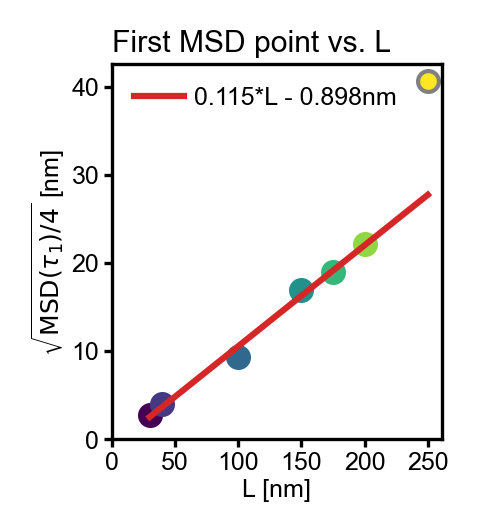

In [11]:
plt.figure(figsize=[2.2, 2.5])

for cond, L, msd1 in zip(conditions, Ls, MSD1):
    mke = None if L < 250 else 'gray'
    plt.plot(L, np.sqrt(msd1/4),
             marker='o', linestyle='',
             markersize=5,
             markeredgecolor=mke,
             color=colors[cond],
            )

xfit = Ls[:-1]
yfit = np.sqrt(MSD1[:-1]/4)
popt, _ = optimize.curve_fit(lambda x, A, B: A*x+B, xfit, yfit)

plt.plot(Ls, Ls*popt[0]+popt[1], label=f'{popt[0]:.3f}*L - {-popt[1]:.3g}nm', color='tab:red')

plt.legend()
plt.xlim([0, None])
plt.ylim([0, None])
plt.xticks([0, 50, 100, 150, 200, 250])
plt.xlabel('L [nm]')
plt.ylabel(r'$\sqrt{\mathrm{MSD}(\tau_1)/4}$ [nm]')
plt.title('First MSD point vs. L')

plt.savefig('MSD_first_points.pdf')
plt.show()

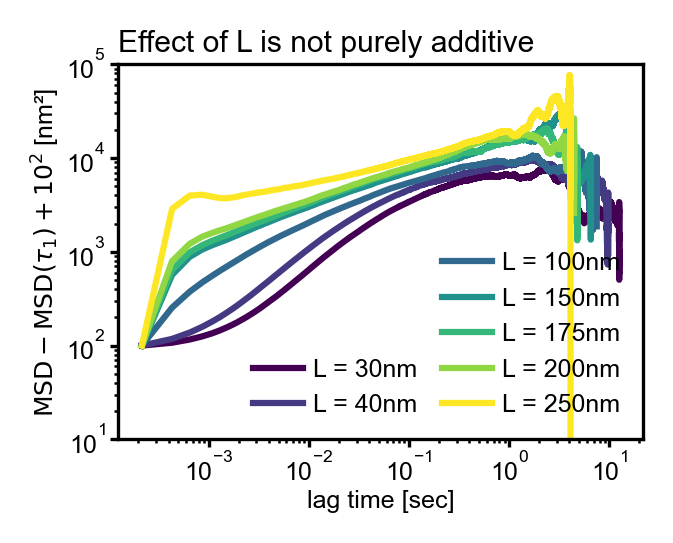

In [12]:
fig = plt.figure(figsize=[3.5, 2.5])
ax = plt.gca()

ax.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment
ax.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment
ax.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment

for L, cond in zip(Ls, conditions):
    dt = dt_H2B

    data.makeSelection(cond)
    msd = nl.analysis.MSD(data)*1e18
    
    msd = msd - msd[1] + 1e2
    
    ax.plot(dt*np.arange(1, len(msd)), msd[1:],
            color=colors[cond],
            # label=cond,
            label=f"L = {L}nm",
           )

ax.legend(loc='lower right', ncol=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e1, 1e5])
ax.set_xlabel('lag time [sec]')
ax.set_ylabel(r'$\mathrm{MSD} - \mathrm{MSD}(\tau_1) + 10^2$ [nm²]')
ax.set_title('Effect of L is not purely additive')

plt.savefig('MSDs_L-sweep_pinned_first_point.pdf')
plt.show()

## Gap distribution

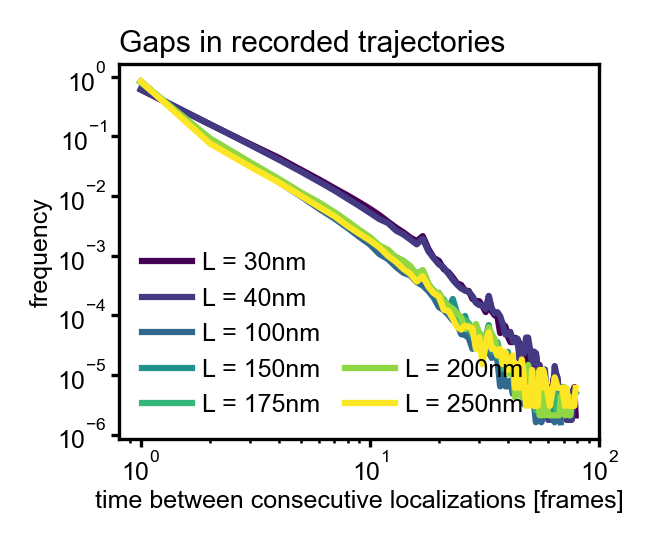

In [11]:
fig = plt.figure(figsize=[3.2, 2.5])

f_single_frame_gaps = []
for L, cond in zip(Ls, conditions):
    data.makeSelection(cond)
    # data.refineSelection(lambda traj, _: traj.F/traj.T > 0.5)
    
    time_steps = []
    for i, traj in enumerate(data):
        ti = np.nonzero(~np.any(np.isnan(traj[:]), axis=-1))[0]
        time_steps.append(np.diff(ti))
    
    time_steps = np.concatenate(time_steps)
    dts, Ns = np.unique(time_steps, return_counts=True)
    
    f_single_frame_gaps.append(Ns[0]/np.sum(Ns))

    plt.plot(dts, Ns/np.sum(Ns),
             color=colors[cond],
             # label=cond,
             label=f'L = {L}nm',
            )

    if L == 175:
        plt.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment
        plt.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment
        plt.plot(0, 0, alpha=0, label=' ') # dummy to fix legend alignment

plt.legend(loc='lower left', ncol=2)
plt.xlabel('time between consecutive localizations [frames]')
plt.ylabel('frequency')
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
plt.xticks([1, 1e1, 1e2])
plt.title('Gaps in recorded trajectories')

plt.savefig('gap_lengths_log.pdf')
plt.show()

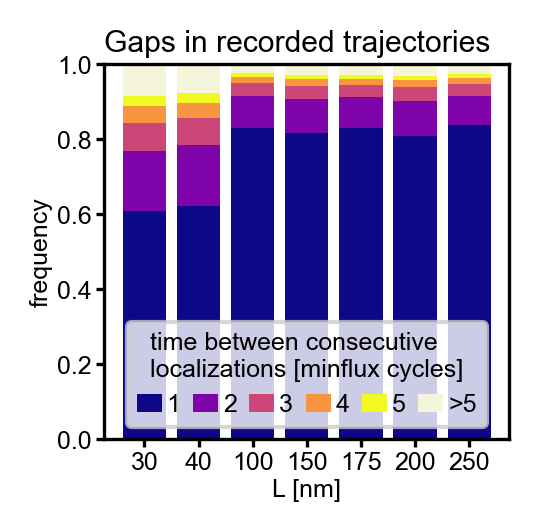

In [21]:
fs = []
for cond in conditions:
    data.makeSelection(cond)
    
    time_steps = []
    for i, traj in enumerate(data):
        ti = np.nonzero(~np.any(np.isnan(traj[:]), axis=-1))[0]
        time_steps.append(np.diff(ti))
    
    time_steps = np.concatenate(time_steps)
    dts, Ns = np.unique(time_steps, return_counts=True)

    myfs = np.zeros(np.max(dts)+1, dtype=float)
    myfs[dts] = Ns/np.sum(Ns)
    fs.append(myfs)

max_dt = max(map(len, fs))
all_fs = np.zeros((len(fs), max_dt), dtype=float)
for i, f in enumerate(fs):
    all_fs[i, :len(f)] = f

# all_fs: (cond, dt)

fig = plt.figure(figsize=[2.7, 2.5])

dt_max_plot = 5
for dt in range(1, dt_max_plot+1):
    color = plt.cm.plasma((dt-1)/(dt_max_plot-1))
    plt.bar(np.arange(len(Ls)), all_fs[:, dt],
            bottom=np.sum(all_fs[:, :dt], axis=1),
            label=f'{dt}',
            width=0.8,
            color=color,
           )
plt.bar(np.arange(len(Ls)), np.sum(all_fs[:, (dt_max_plot+1):], axis=1),
        bottom=np.sum(all_fs[:, :(dt_max_plot+1)], axis=1),
        label=f'>{dt_max_plot}',
        width=0.8,
        color='beige',
       )

plt.legend(loc='lower center',
           frameon=True,
           ncol=6,
           handlelength=1,
           handletextpad=0.2,
           columnspacing=0.5,
           # framealpha=0.8,
           title='time between consecutive\nlocalizations [minflux cycles]',
          )
plt.xlabel('L [nm]')
plt.ylabel('frequency')
plt.xticks(np.arange(len(Ls)), list(map(str, Ls)))
plt.ylim([0, 1])
plt.title('Gaps in recorded trajectories')

plt.savefig('gaps_barplot.pdf')
plt.show()